In [137]:
import importlib
import sys
from pathlib import Path
import os
from rich.pretty import pprint
import json
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo
import re
from functools import partial

from hydra import compose, initialize
import dotenv
import hydra
import pytorch_lightning as pl
import torch
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
from inz.data.data_module import XBDDataModule
from inz.data.event import Event, Hold, Tier1, Tier3, Test
from inz.util import show_masks_comparison
from PIL import Image
from torchvision.utils import draw_segmentation_masks, make_grid  # type: ignore[import-untyped]
from torchvision.io import read_image  # type: ignore[import-untyped]
import torchvision.transforms as T

from pytorch_grad_cam import (
    GradCAM,
    HiResCAM,
    ScoreCAM,
    GradCAMPlusPlus,
    AblationCAM,
    XGradCAM,
    EigenCAM,
    FullGrad,
    EigenGradCAM,
    LayerCAM,
    DeepFeatureFactorization,
    GradCAMElementWise,
)
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import wandb

from inz.data.data_module_frnet import FRNetModule

sys.path.append("inz/farseg")
sys.path.append("inz/dahitra")

In [138]:
dotenv.load_dotenv()
RANDOM_SEED = 123
pl.seed_everything(RANDOM_SEED)
device = torch.device("cuda")
torch.set_float32_matmul_precision("high")

assert (WANDB_API_KEY := os.getenv("WANDB_API_KEY")), "No API key specified"
wandb.login(key=WANDB_API_KEY, verify=True)
api = wandb.Api()

Seed set to 123
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/tomek/.netrc


In [155]:
from typing import Literal


# RUN_NAME, RUN_ID = "farseg_single", "i7uqnpru"
# RUN_NAME, RUN_ID = "t_floodnet_msl_farseg_single", "e36x64n1"

# RUN_NAME, RUN_ID = "farseg_singlebranch_flood", "81xc6u33"
# RUN_NAME, RUN_ID = "t_floodnet_msl_farseg_singlebranch_flood", "44glt8kq"

# RUN_NAME, RUN_ID = "baseline_singlebranch", "ix1yzkne"
# RUN_NAME, RUN_ID = "t_floodnet_msl_baseline_singlebranch", "0gdoeviz"

# RUN_NAME, RUN_ID = "baseline_singlebranch_flood", "j936conc"
RUN_NAME, RUN_ID = "t_floodnet_msl_baseline_singlebranch_flood", "v8zpug4r"

DM: Literal["xBD", "FloodNet", "RescueNet"]
# DM = "xBD"
DM = "FloodNet"
# DM = "RescueNet"

IMG_NAME_XBD = "hurricane-michael_00000084_post_disaster_patch0"

IMG_NAME_FLOODNET = "7595"
# IMG_NAME_FLOODNET = "7308"

FARSEG_GRADCAM_TARGET: Literal["foreground", "background"] = "foreground"
# FARSEG_GRADCAM_TARGET: Literal["foreground", "background"] = "background"

using weights from ResNet34_Weights.IMAGENET1K_V1

Run name: t_floodnet_msl_baseline_singlebranch_flood
Run id: v8zpug4r
Model: SingleBranchBaselinePLModule
Checkpoint path: outputs/t_floodnet_msl_baseline_singlebranch_flood/2024-12-27T20:44:02/checkpoints/t_floodnet_msl_baseline_singlebranch_flood-epoch=01-step=544-challenge_score_target=0.6325-best-challenge-floodnet.ckpt

Wrapping in MSL
data/floodnet_processed_512/FloodNet-Supervised_v1.0/test/test-org-img/7595.png
Ground truth


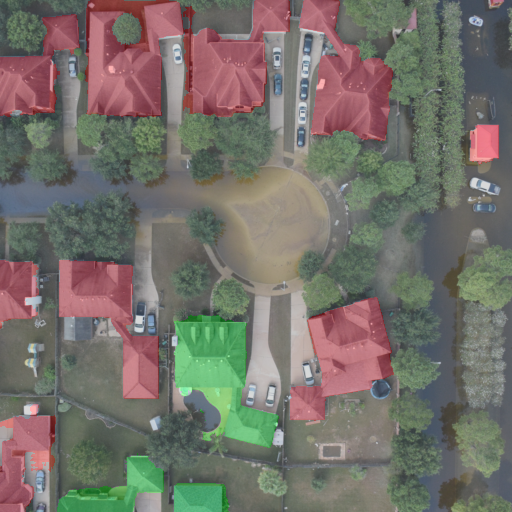

Preds (t_floodnet_msl_baseline_singlebranch_flood)


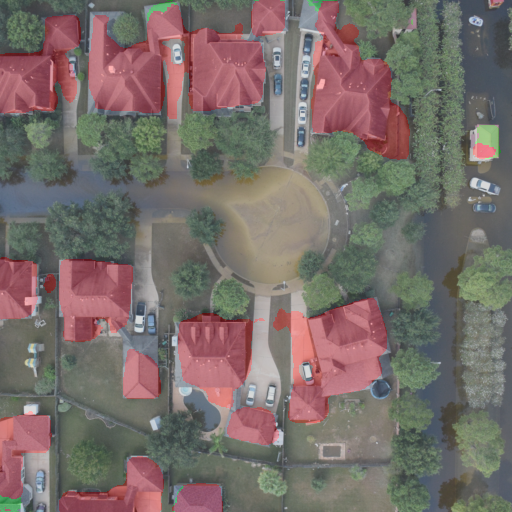

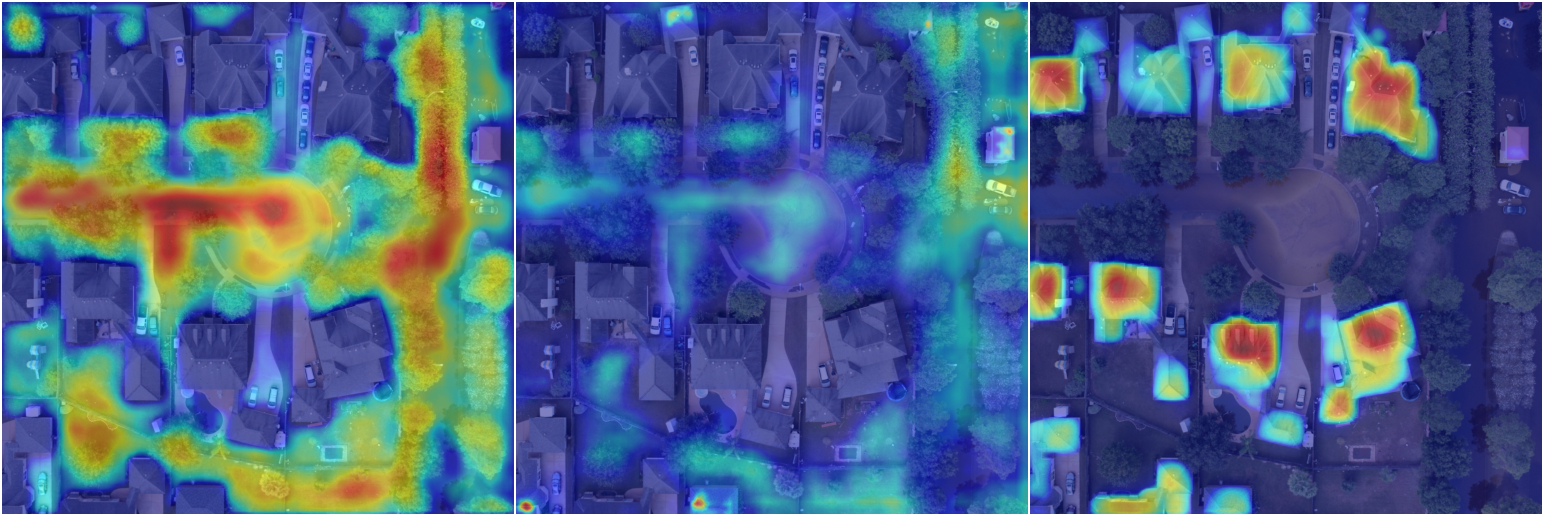

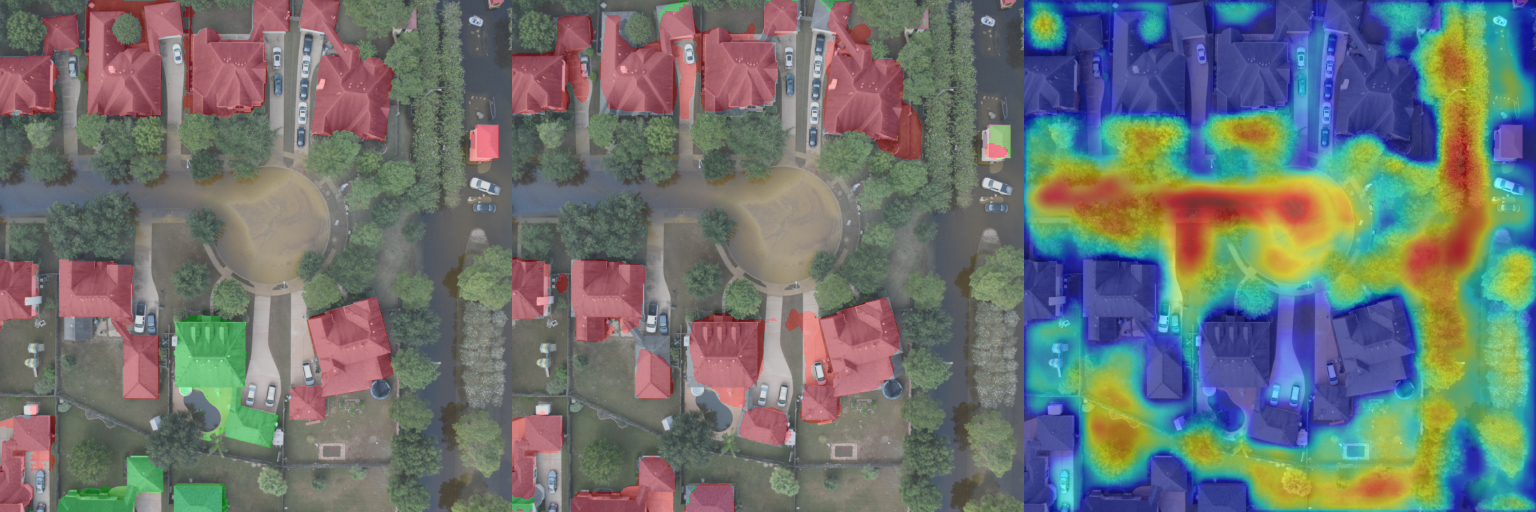

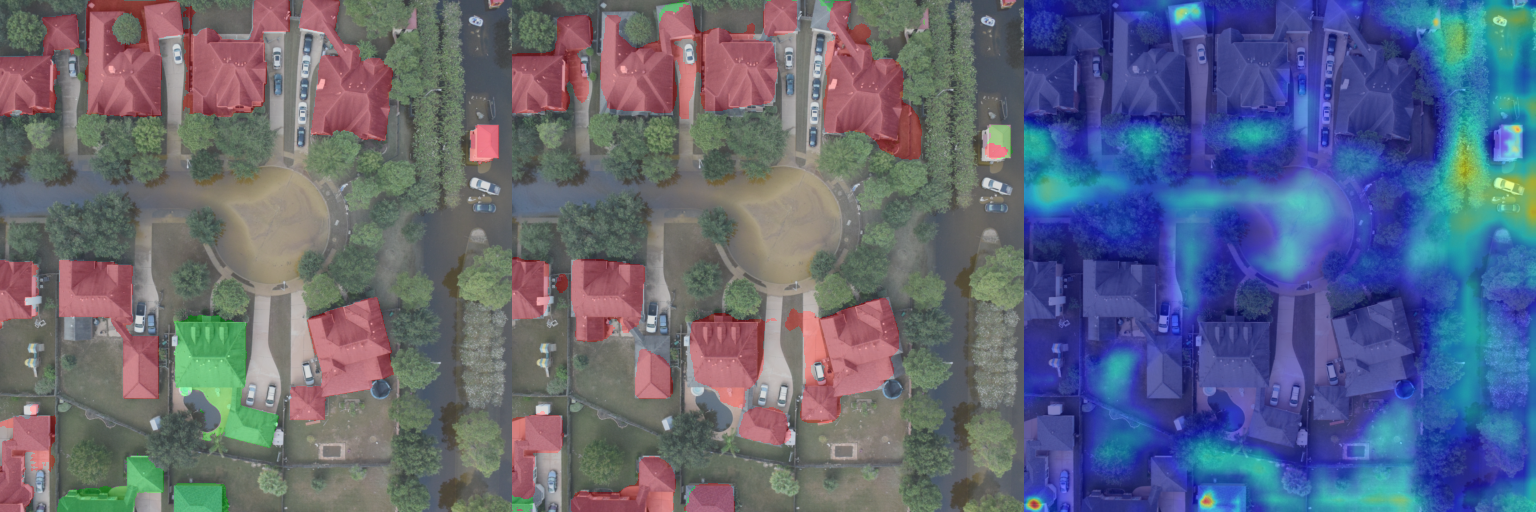

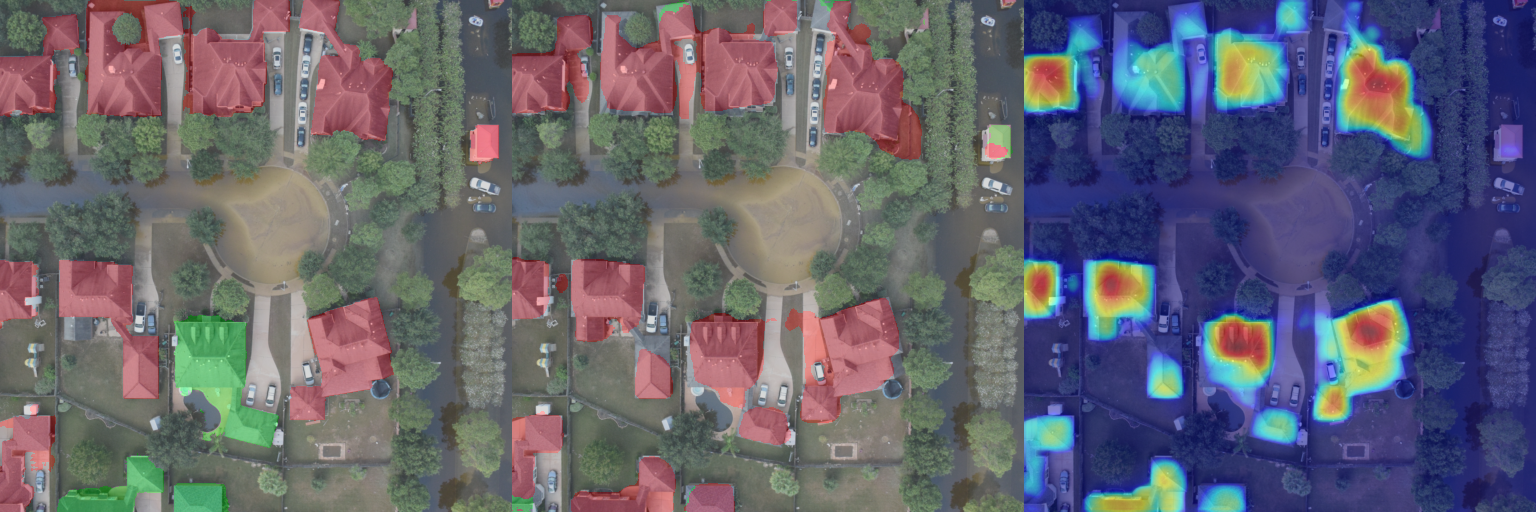

In [156]:
# region boring

from inz.models.baseline_module import BaselineModule
from inz.models.baseline_singlebranch import SingleBranchBaselinePLModule
from inz.models.dahitra_module import DahitraPLModule
from inz.models.farseg_module import DoubleBranchFarSegModule
from inz.models.farseg_singlebranch_module import SingleBranchFarSegModule
from inz.models.msl.msl_module_wrapper import BaseMSLModuleWrapper, FloodNetMslModuleWrapper, RescueNetMslModuleWrapper


filters = {"display_name": {"$regex": RUN_NAME}} | ({"name": RUN_ID} if RUN_ID else {})

runs = api.runs(path="tomasz-owienko-stud-warsaw-university-of-technology/inz", filters=filters)

assert len(runs) == 1, f"Len runs is {len(runs)}"
run = runs[0]
run_id = run.id
run_created_at = datetime.fromisoformat(run._attrs["createdAt"])
try:
    cfg = (
        json.loads(run.json_config)["hydra_cfg"]["value"]
        .replace("'", '"')
        .replace("True", "true")
        .replace("False", "false")
    )
    cfg = json.loads(cfg)
except KeyError as e:
    if RUN_NAME == "baseline_singlebranch":
        import yaml

        with open("config/module/baseline/baseline_singlebranch.yaml") as fp:
            cfg = { "module": yaml.safe_load(fp) }
    else:
        raise e

OUTPUTS_PATH = Path("outputs")
run_dirs = list((OUTPUTS_PATH / RUN_NAME).glob("*/"))
dates_dirs = {
    (
        datetime.fromisoformat(run_dir.resolve().stem)
        if "T" in run_dir.resolve().stem
        else datetime.strptime(run_dir.resolve().stem, r"%Y-%m-%d_%H-%M-%S")
    ).replace(tzinfo=ZoneInfo("Europe/Warsaw"))
    - run_created_at: run_dir
    for run_dir in run_dirs
}

CHECKPOINTS_PATH = min(dates_dirs.items(), key=lambda kv: abs(kv[0]))[1] / "checkpoints"

challenge_score_checkpoints = CHECKPOINTS_PATH.rglob("./*-challenge_score*.ckpt")
ckpt_paths_with_scores = []
for path in challenge_score_checkpoints:
    match = (
        re.search(r".*-challenge_score_safe-(0.\d+)-.*", path.stem)
        or re.search(r".*-challenge_score_safe=(0.\d+)-.*", path.stem)
        or re.search(r".*-challenge_score_target=(0.\d+)-.*", path.stem)
    )
    if match:
        ckpt_paths_with_scores.append((float(match.group(1)), path))
if not ckpt_paths_with_scores:
    print("COULD NOT FIND CHALLENGE SCORE CHECKPOINT, USING F1 INSTEAD")
    challenge_score_checkpoints = CHECKPOINTS_PATH.rglob("./*-best-f1*.ckpt")
    ckpt_paths_with_scores = []
    for path in challenge_score_checkpoints:
        match = re.search(r".*(0.\d+)-best-f1.*", path.stem)
        ckpt_paths_with_scores.append((float(match.group(1)), path))

CKPT_PATH = max(ckpt_paths_with_scores, key=lambda sp: sp[0])[1]

model_class_str = cfg["module"]["module"]["_target_"]
model_class_name = model_class_str.split(".")[-1]
module_path = ".".join(model_class_str.split(".")[:-1])
imported_module = importlib.import_module(module_path)
model_class = getattr(imported_module, model_class_name)
model_partial = hydra.utils.instantiate(cfg["module"]["module"])

msg = f"""
Run name: {RUN_NAME}
Run id: {RUN_ID}
Model: {model_class.__name__}
Checkpoint path: {CKPT_PATH}
"""
print(msg)

if "msl" in RUN_NAME:
    print("Wrapping in MSL")
    model_msl = BaseMSLModuleWrapper.load_from_checkpoint(
        CKPT_PATH, pl_module=model_partial(), msl_loss_module=None
    ).to(device)
    model = model_msl.inner
else:
    model = model_class.load_from_checkpoint(CKPT_PATH, *model_partial.args, **model_partial.keywords).to(device)

model.eval()

if DM == "xBD":
    dm = XBDDataModule(
        path=Path("data/xBD_processed_512"),
        drop_unclassified_channel=True,
        split_events={
            "test": {
                Tier1: [
                    Event.guatemala_volcano,
                    Event.hurricane_florence,
                    Event.hurricane_harvey,
                    Event.hurricane_matthew,
                    Event.hurricane_michael,
                    Event.mexico_earthquake,
                    Event.midwest_flooding,
                    Event.palu_tsunami,
                    Event.santa_rosa_wildfire,
                    Event.socal_fire,
                ],
                Test: [
                    Event.guatemala_volcano,
                    Event.hurricane_florence,
                    Event.hurricane_harvey,
                    Event.hurricane_matthew,
                    Event.hurricane_michael,
                    Event.mexico_earthquake,
                    Event.midwest_flooding,
                    Event.palu_tsunami,
                    Event.santa_rosa_wildfire,
                    Event.socal_fire,
                ],
                Hold: [
                    Event.guatemala_volcano,
                    Event.hurricane_florence,
                    Event.hurricane_harvey,
                    Event.hurricane_matthew,
                    Event.hurricane_michael,
                    Event.mexico_earthquake,
                    Event.midwest_flooding,
                    Event.palu_tsunami,
                    Event.santa_rosa_wildfire,
                    Event.socal_fire,
                ],
                Tier3: [
                    Event.joplin_tornado,
                    Event.lower_puna_volcano,
                    Event.moore_tornado,
                    Event.nepal_flooding,
                    Event.pinery_bushfire,
                    Event.portugal_wildfire,
                    Event.sunda_tsunami,
                    Event.tuscaloosa_tornado,
                    Event.woolsey_fire,
                ],
            }
        },
        train_batch_size=1,
        val_batch_size=1,
        test_batch_size=1,
    )
elif DM == "FloodNet":
    dm = FRNetModule(
        path=Path("data/floodnet_processed_512/FloodNet-Supervised_v1.0"),
        train_batch_size=1,
        val_batch_size=1,
        test_batch_size=1,
        transform=T.Compose(
            transforms=[
                T.RandomHorizontalFlip(p=0.5),
                T.RandomApply(
                    p=0.6, transforms=[T.RandomAffine(degrees=(-10, 10), scale=(0.9, 1.1), translate=(0.1, 0.1))]
                ),
            ]
        ),
    )
else:
    raise NotImplementedError("RescueNet")

dm.prepare_data()
dm.setup("test")


class SemanticSegmentationTarget:
    def __init__(self, category, mask):
        self.category = category
        self.mask = mask
        if torch.cuda.is_available():
            self.mask = self.mask.cuda()

    def __call__(self, model_output):
        return (model_output[self.category, :, :] * self.mask).sum()


if DM == "xBD":
    IMG_PATH_POST = next(Path("data/xBD_processed_512/images").rglob(f"*/images/{IMG_NAME_XBD}.png"))
elif DM == "FloodNet":
    try:
        IMG_PATH_POST = next(Path("data/floodnet_processed_512/FloodNet-Supervised_v1.0/test/test-org-img").rglob(f"**/{IMG_NAME_FLOODNET}.png"))
    except StopIteration:
        IMG_PATH_POST = next(Path("data/floodnet_processed_512/FloodNet-Supervised_v1.0/val/val-org-img").rglob(f"**/{IMG_NAME_FLOODNET}.png"))
    print(IMG_PATH_POST)
    exit(1)
else:
    raise NotImplementedError("RescueNet")


if isinstance(model, DoubleBranchFarSegModule) or isinstance(model, SingleBranchFarSegModule):
    if FARSEG_GRADCAM_TARGET == "background":
        # ALLOWS TO PREVIEW BACKGROUND MASKS
        target_layers = model.model.module.sr.content_encoders
    else:
        target_layers = model.model.module.decoder.blocks[:-3]
        # target_layers = model.model.module.sr.feature_reencoders
elif isinstance(model, BaselineModule) or isinstance(model, SingleBranchBaselinePLModule):
    target_layers = [
        # model.model.conv3
        model.model.conv6_2,
        model.model.conv7_2,
        model.model.conv8_2,
        model.model.conv9_2,
        # model.model.conv10,
        # model.model.res,
    ]
    # target_layers = [
    #     model.model.conv1,
    #     model.model.conv2,
    #     model.model.conv3,
    # model.model.conv4,
    # model.model.conv5,
    # ]
elif isinstance(model, DahitraPLModule):
    target_layers = [
        model.model.module.conv_decode_5,
        model.model.module.conv_decode_4,
        model.model.module.conv_decode_3,
        model.model.module.conv_decode_5,
    ]

else:
    raise NotImplementedError(f"Gradcam not implemented for model {model_class.__name__}")

if DM == "xBD":
    item = dm._test_dataset[dm._test_dataset._image_paths_post.index(IMG_PATH_POST)]
elif DM == "FloodNet":
    item = dm._test_dataset[dm._test_dataset.image_paths.index(IMG_PATH_POST)]
else:
    raise NotImplementedError("RescueNet")
image_pre, mask_pre, image_post, mask_post = item


with torch.no_grad():

    if DM == "FloodNet":
        m = FloodNetMslModuleWrapper(
            pl_module=model,
            n_classes_target=3,
            msl_loss_module=None,
            msl_lambda=None,
            optimizer_factory=None
        ).to(device)
    elif DM == "RescueNet":
        m = RescueNetMslModuleWrapper(
            pl_module=model,
            n_classes_target=5,
            msl_loss_module=None,
            msl_lambda=None,
            optimizer_factory=None
        ).to(device)
    else:
        m = model.to(device)

    preds = m(torch.cat([torch.unsqueeze(image_pre, 0), torch.unsqueeze(image_post, 0)], dim=1).to(device))

if DM in ("xBD", "RescueNet"):
    N_CLASSES = 5
    colors = [
        (128, 128, 128),
        (0, 255, 0),
        (244, 255, 0),
        (255, 174, 0),
        (255, 0, 0),
        (255, 255, 255),
    ]
else:
    N_CLASSES = 3
    colors = [
        (128, 128, 128),
        (0, 255, 0),
        (255, 0, 0),
    ]

preds_masks = draw_segmentation_masks(
    ((image_post + 1) * 127.5).to(torch.uint8),
    torch.nn.functional.one_hot(preds[0].argmax(dim=0), num_classes=N_CLASSES).moveaxis(-1, 0).to(bool),
    colors=colors,
    alpha=0.3,
)
ground_truth_masks = draw_segmentation_masks(
    ((image_post + 1) * 127.5).to(torch.uint8), mask_post.to(bool), colors=colors, alpha=0.3
)
pre_disaster_masks = draw_segmentation_masks(
    ((image_pre + 1) * 127.5).to(torch.uint8), mask_pre.to(bool), colors=colors, alpha=0.3
)

if DM not in ("FloodNet", "RescueNet"):
    print("Pre-disaster")
    display(Image.fromarray(pre_disaster_masks.moveaxis(0, -1).detach().cpu().numpy()))

print("Ground truth")
display(Image.fromarray(ground_truth_masks.moveaxis(0, -1).detach().cpu().numpy()))
print(f"Preds ({RUN_NAME})")
display(Image.fromarray(preds_masks.moveaxis(0, -1).detach().cpu().numpy()))

GRADCAM_CLASS = GradCAM

acts = []
for c in range(0, N_CLASSES):
    targets = [SemanticSegmentationTarget(c, mask_post.argmax(axis=0))]
    with GRADCAM_CLASS(
        model=model,
        target_layers=target_layers,
    ) as cam:
        grayscale_cam = cam(
            input_tensor=torch.unsqueeze(torch.cat([image_pre, image_post], dim=0), 0), targets=targets
        )[0, :]
        cam_image = show_cam_on_image(
            ((image_post + 1) / 2).moveaxis(0, -1).detach().cpu().numpy(), grayscale_cam, use_rgb=True
        )

    acts.append(torch.from_numpy(cam_image).moveaxis(-1, 0))
comp_acts = make_grid(torch.stack(acts), padding=2, pad_value=255)
display(Image.fromarray(comp_acts.moveaxis(0, -1).numpy()))


for c in range(0, N_CLASSES):
    targets = [SemanticSegmentationTarget(c, mask_post.argmax(axis=0))]
    with GRADCAM_CLASS(
        model=model,
        target_layers=target_layers,
    ) as cam:
        grayscale_cam = cam(
            input_tensor=torch.unsqueeze(torch.cat([image_pre, image_post], dim=0), 0), targets=targets
        )[0, :]
        cam_image = show_cam_on_image(
            ((image_post + 1) / 2).moveaxis(0, -1).detach().cpu().numpy(), grayscale_cam, use_rgb=True
        )

    comp = np.hstack(
        (
            ground_truth_masks.moveaxis(0, -1).detach().cpu().numpy(),
            preds_masks.moveaxis(0, -1).detach().cpu().numpy(),
            cam_image,
        )
    )
    display(Image.fromarray(comp))

# endregion

## Do weryfikacji metryk

In [141]:

# import torchmetrics.classification

# f1_class_wise_m = torchmetrics.classification.MulticlassF1Score(num_classes=3, average='none')
# f1_loc_m = torchmetrics.classification.BinaryF1Score()

# with torch.no_grad():
#     for batch in dm.test_dataloader():
#         image_pre, mask_pre, image_post, mask_post = batch
#         preds = m(torch.cat([image_pre, image_post], dim=1).to(device))
#         preds_argmax = preds.argmax(dim=1).cpu()
#         mask_argmax = mask_post.argmax(dim=1)

#         f1_class_wise_m(preds_argmax, mask_argmax)
#         f1_loc_m((preds_argmax > 0).to(torch.int), (mask_argmax > 0).to(torch.int))

# f1_0, f1_1, f1_2 = f1_class_wise_m.compute()
# f1_loc = f1_loc_m.compute()

In [142]:

# print(f1_0, f1_1, f1_2)
# print(f1_loc)
# print(0.3 * f1_loc + 0.7 * 3 / (1/f1_0 + 1/f1_1 + 1/f1_2))
